## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [8]:
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


W0717 21:44:53.869548 11484 deprecation_wrapper.py:119] From C:\Users\USER\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0717 21:44:53.871544 11484 deprecation_wrapper.py:119] From C:\Users\USER\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0717 21:44:53.901998 11484 deprecation_wrapper.py:119] From C:\Users\USER\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 21:44:53.903305 11484 deprecation_wrapper.py:119] From C:\Users\USER\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0717 21:44:54.279516 11484 deprecation.py:323] From C:\Users\USER\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 13s 254us/step - loss: 15.0890 - acc: 0.2615 - val_loss: 13.9551 - val_acc: 0.3383
Epoch 2/50
50000/50000 [==============================] - 12s 237us/step - loss: 13.0218 - acc: 0.3568 - val_loss: 12.1235 - val_acc: 0.3718ss: 13.
Epoch 3/50
50000/50000 [==============================] - 12s 237us/step - loss: 11.3426 - acc: 0.3831 - val_loss: 10.5917 - val_acc: 0.3844
Epoch 4/50
50000/50000 [==============================] - 12s 237us/step - loss: 9.9294 - acc: 0.3967 - val_loss: 9.2902 - val_acc: 0.4041
Epoch 5/50
50000/50000 [==============================] - 12s 232us/step - loss: 8.7287 - acc: 0.4092 - val_loss: 8.1872 - val_acc: 0.4114
Epoch 6/50
50000/50000 [==============================] - 12s 234us/step - loss: 7.7063 - acc: 0.4155 - val_loss: 7.2492 - val_acc: 0.4178
Epoch 7/50
50000/50000 [==============================] - 11s 227us/step - loss: 6.8371 - acc: 0.4204 -

50000/50000 [==============================] - 12s 240us/step - loss: 2.1937 - acc: 0.2682 - val_loss: 2.0091 - val_acc: 0.3382
Epoch 2/50
50000/50000 [==============================] - 12s 236us/step - loss: 1.9489 - acc: 0.3634 - val_loss: 1.9015 - val_acc: 0.3791
Epoch 3/50
50000/50000 [==============================] - 12s 236us/step - loss: 1.8624 - acc: 0.3966 - val_loss: 1.8338 - val_acc: 0.4056
Epoch 4/50
50000/50000 [==============================] - 12s 234us/step - loss: 1.8045 - acc: 0.4174 - val_loss: 1.7885 - val_acc: 0.4202
Epoch 5/50
50000/50000 [==============================] - 12s 235us/step - loss: 1.7580 - acc: 0.4343 - val_loss: 1.7528 - val_acc: 0.4355
Epoch 6/50
50000/50000 [==============================] - 12s 235us/step - loss: 1.7175 - acc: 0.4479 - val_loss: 1.7274 - val_acc: 0.4404
Epoch 7/50
50000/50000 [==============================] - 12s 234us/step - loss: 1.6864 - acc: 0.4583 - val_loss: 1.6998 - val_acc: 0.4437
Epoch 8/50
50000/50000 [==============

Epoch 2/50
50000/50000 [==============================] - 12s 236us/step - loss: 1.8083 - acc: 0.3646 - val_loss: 1.7540 - val_acc: 0.3842
Epoch 3/50
50000/50000 [==============================] - 12s 237us/step - loss: 1.7242 - acc: 0.3951 - val_loss: 1.6968 - val_acc: 0.4010
Epoch 4/50
50000/50000 [==============================] - 12s 240us/step - loss: 1.6681 - acc: 0.4143 - val_loss: 1.6495 - val_acc: 0.4217
Epoch 5/50
50000/50000 [==============================] - 12s 241us/step - loss: 1.6217 - acc: 0.4293 - val_loss: 1.6143 - val_acc: 0.4333
Epoch 6/50
50000/50000 [==============================] - 12s 234us/step - loss: 1.5822 - acc: 0.4446 - val_loss: 1.5731 - val_acc: 0.4459
Epoch 7/50
50000/50000 [==============================] - 12s 237us/step - loss: 1.5487 - acc: 0.4568 - val_loss: 1.5570 - val_acc: 0.4470
Epoch 8/50
50000/50000 [==============================] - 12s 240us/step - loss: 1.5194 - acc: 0.4670 - val_loss: 1.5278 - val_acc: 0.4576
Epoch 9/50
50000/50000 [===

50000/50000 [==============================] - 12s 238us/step - loss: 1.8108 - acc: 0.3641 - val_loss: 1.7586 - val_acc: 0.3851
Epoch 3/50
50000/50000 [==============================] - 13s 250us/step - loss: 1.7292 - acc: 0.3943 - val_loss: 1.7018 - val_acc: 0.4033
Epoch 4/50
50000/50000 [==============================] - 12s 245us/step - loss: 1.6714 - acc: 0.4136 - val_loss: 1.6458 - val_acc: 0.4256
Epoch 5/50
50000/50000 [==============================] - 12s 235us/step - loss: 1.6226 - acc: 0.4315 - val_loss: 1.6020 - val_acc: 0.4370
Epoch 6/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.5828 - acc: 0.4460 - val_loss: 1.5765 - val_acc: 0.4487
Epoch 7/50
50000/50000 [==============================] - 12s 239us/step - loss: 1.5505 - acc: 0.4560 - val_loss: 1.5560 - val_acc: 0.4504
Epoch 8/50
50000/50000 [==============================] - 12s 238us/step - loss: 1.5202 - acc: 0.4680 - val_loss: 1.5414 - val_acc: 0.4512
Epoch 9/50
50000/50000 [==============

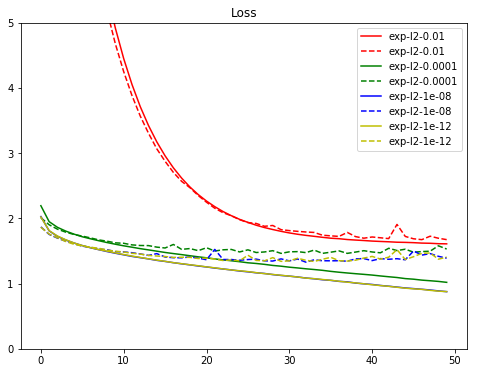

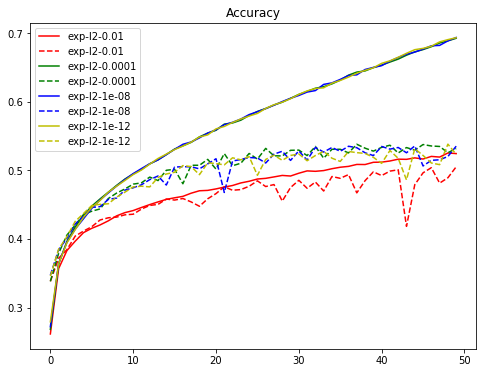

In [9]:
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()